In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time

import matplotlib.pyplot as plt

import scipy
from scipy import linalg

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from WrapScalableSVM import *
from Utils_SSVM import *
from utilsData import *
from modelEvaluation import *
from utilsPlot import *

import joblib

# Tests for the xAI-2024 conference paper
# Load datasets

In [2]:
datapath = "simulationVictorTopological/"
train = "train.csv"
test = "test.csv"
cal = "calib.csv"

In [3]:
dbtrain = pd.read_csv(datapath+train)
dbtest = pd.read_csv(datapath+test)
dbcal = pd.read_csv(datapath+cal)
dbtrain

,SafetyMargin,Eta,Tau,meanEntropy,medianEntropy,stdsEntropy,iqrsEntropy,output
0,0.164383,0.753979,0.528261,2.742946,2.74330,0.019901,0.024050,0
1,0.244039,0.672279,0.722540,2.736865,2.74080,0.028210,0.041500,13
2,0.211727,0.437306,0.046253,2.760221,2.75830,0.023566,0.032725,0
3,0.022487,0.171330,0.900063,2.644413,2.64530,0.029735,0.037525,0
4,0.417714,0.946943,0.894493,2.769786,2.77180,0.023567,0.035950,14
...,...,...,...,...,...,...,...,...
3995,0.412685,0.702831,0.157536,2.787424,2.79285,0.024404,0.038825,19
3996,0.151167,0.383013,0.226184,2.738770,2.74140,0.021061,0.030800,0
3997,0.200072,0.945328,0.217403,2.762945,2.76460,0.016421,0.022900,0
3998,0.082767,0.152588,0.592013,2.695922,2.69975,0.021611,0.028900,0


Separate features and labels, and convert label 0 with 1 and 1 with -1

In [6]:
Xtr = dbtrain[['SafetyMargin', 'Eta', 'Tau','meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy']].values
Ytr = dbtrain[['output']].values
Ytr[Ytr>1] = -1
Ytr[Ytr==0] = 1

Xts = dbtest[['SafetyMargin', 'Eta', 'Tau','meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy']].values
Yts = dbtest[['output']].values
Yts[Yts>1] = -1
Yts[Yts==0] = 1

Xcal = dbcal[['SafetyMargin', 'Eta', 'Tau','meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy']].values
Ycal = dbcal[['output']].values
Ycal[Ycal>1] = -1
Ycal[Ycal==0] = 1

# Exploratory analisis

In [7]:
correlation_matrix = dbtrain.corr()
print(correlation_matrix)

dbtrain['outputTrans'] = dbtrain['output'].apply(lambda x: 1 if x > 0 else -1)
dbtrain

               SafetyMargin       Eta       Tau  meanEntropy  medianEntropy  \
SafetyMargin       1.000000 -0.005526  0.027741     0.917064       0.915132   
Eta               -0.005526  1.000000 -0.017069     0.052365       0.051106   
Tau                0.027741 -0.017069  1.000000    -0.103992      -0.107366   
meanEntropy        0.917064  0.052365 -0.103992     1.000000       0.997176   
medianEntropy      0.915132  0.051106 -0.107366     0.997176       1.000000   
stdsEntropy       -0.309586 -0.050524 -0.076379    -0.398809      -0.387165   
iqrsEntropy       -0.104751 -0.040040 -0.064665    -0.199933      -0.197123   
output             0.895919  0.013104 -0.024366     0.789916       0.788659   
outputTrans        0.828473  0.010635 -0.024801     0.745319       0.745520   

               stdsEntropy  iqrsEntropy    output  outputTrans  
SafetyMargin     -0.309586    -0.104751  0.895919     0.828473  
Eta              -0.050524    -0.040040  0.013104     0.010635  
Tau           

,SafetyMargin,Eta,Tau,meanEntropy,medianEntropy,stdsEntropy,iqrsEntropy,output,outputTrans
0,0.164383,0.753979,0.528261,2.742946,2.74330,0.019901,0.024050,0,-1
1,0.244039,0.672279,0.722540,2.736865,2.74080,0.028210,0.041500,13,1
2,0.211727,0.437306,0.046253,2.760221,2.75830,0.023566,0.032725,0,-1
3,0.022487,0.171330,0.900063,2.644413,2.64530,0.029735,0.037525,0,-1
4,0.417714,0.946943,0.894493,2.769786,2.77180,0.023567,0.035950,14,1
...,...,...,...,...,...,...,...,...,...
3995,0.412685,0.702831,0.157536,2.787424,2.79285,0.024404,0.038825,19,1
3996,0.151167,0.383013,0.226184,2.738770,2.74140,0.021061,0.030800,0,-1
3997,0.200072,0.945328,0.217403,2.762945,2.76460,0.016421,0.022900,0,-1
3998,0.082767,0.152588,0.592013,2.695922,2.69975,0.021611,0.028900,0,-1


## Dispersion plots

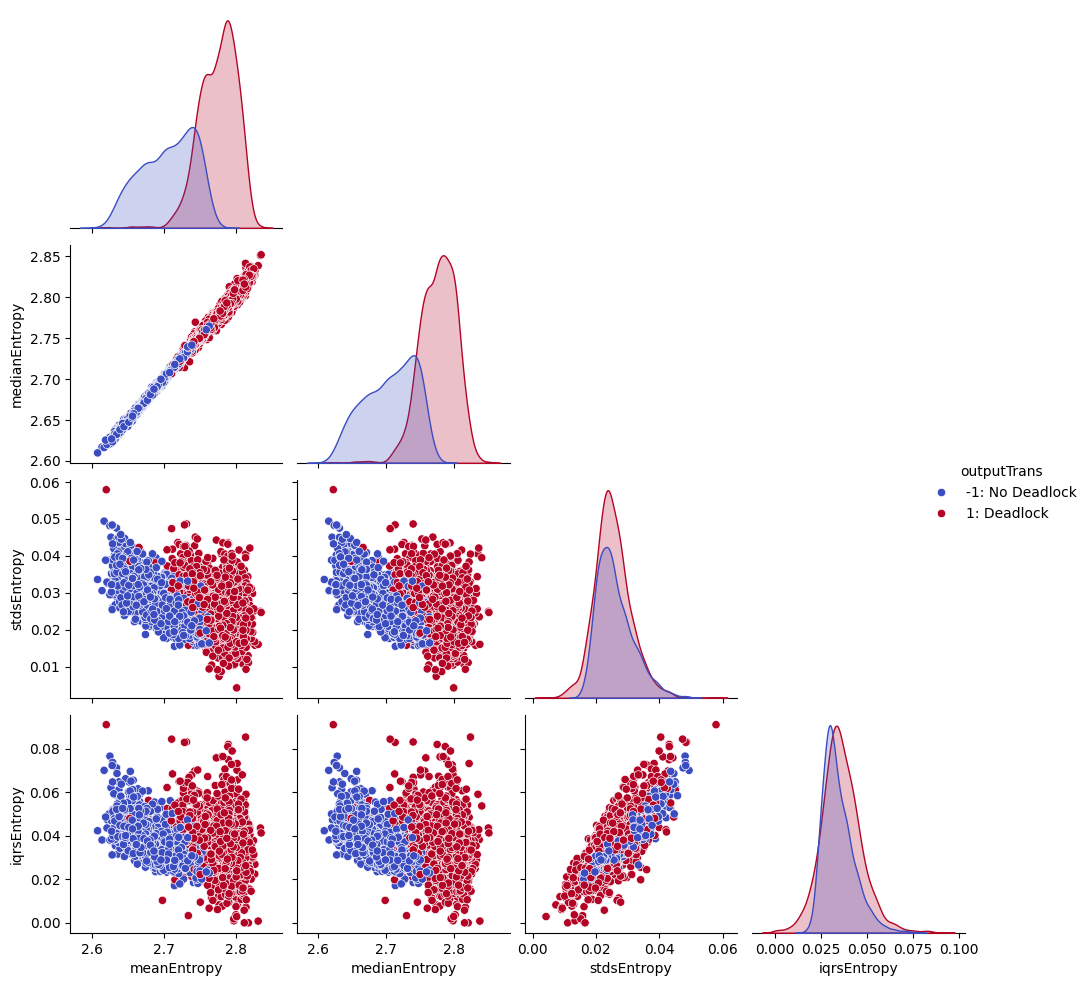

In [8]:
pairplot = sns.pairplot(dbtrain, vars=['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy'], hue='outputTrans', palette='coolwarm',corner=True)
new_labels = ['-1: No Deadlock', '1: Deadlock']  # Nombres personalizados
for t, label in zip(pairplot._legend.texts, new_labels):
    t.set_text(label)
plt.show()

## Boxplots

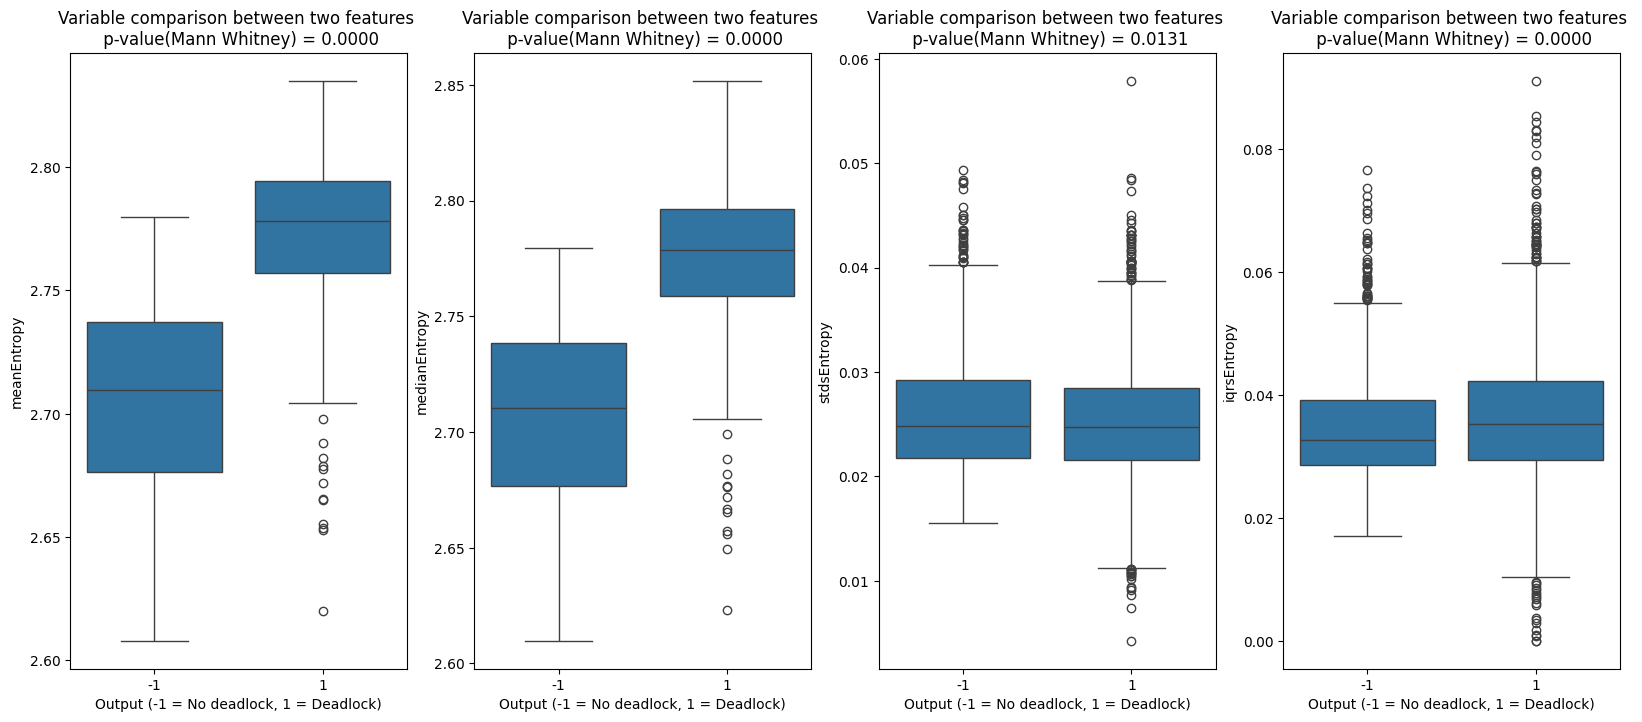

In [9]:
from scipy.stats import mannwhitneyu
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8))
axes = axes.flatten()
for num,i in enumerate(['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy']):
    Cvalues = dbtrain[dbtrain["outputTrans"] == 1][i].values
    NCvalues = dbtrain[dbtrain["outputTrans"] == -1][i].values
    u_stat, p_value = mannwhitneyu(Cvalues, NCvalues, alternative="two-sided")
    plt.sca(axes[num])
    sns.boxplot(x='outputTrans', y=i, data=dbtrain)
    plt.title(f'Variable comparison between two features \n p-value(Mann Whitney) = {p_value:.4f}')
    plt.xlabel("Output (-1 = No deadlock, 1 = Deadlock)")
    plt.ylabel(i)

plt.show()

# SVM parameters setting

In [10]:
# Parameters settings
kernel = "gaussian" #with gaussian work, with polynomial no.
param = 0.5 # play with this to improve model evaluation, explaination on chatgpt
tau = np.array([[0.5]])
eta = 0.3

# Scaling setting

In [11]:
epsilon = 0.1

## 1) Classic SVM

In [12]:
start_time = time.time()

model = ScalableSVMClassifier(eta, kernel, param, tau)

model = model.fit(Xtr[:,-4:],Ytr) #[:,-4:] solo caract topol
joblib.dump(model, datapath+"classicSVM_safeEff.sav")
end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 53.8925507068634 seconds


In [13]:
model = model.FPcontrol(Xcal[:,-4:], Ycal, epsilon,'classic')
model.get_params()

{'alpha': array([4.99955410e-01, 5.00036436e-01, 4.99884052e-01, ...,
        4.99870439e-01, 6.92332551e-05, 4.99887713e-01]),
 'b': array([-0.15650505]),
 'b_eps': 0,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

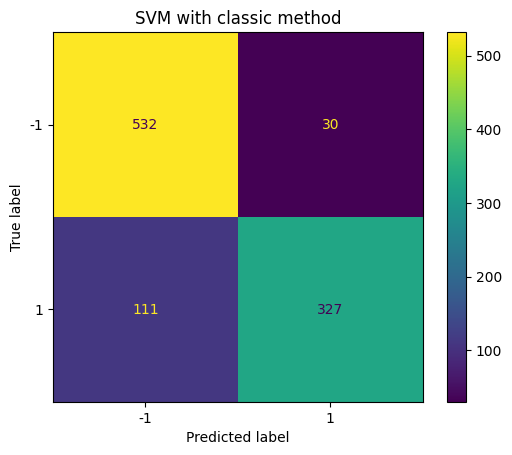

ACC = 0.859, F1 = 0.8226415094339623, PPV = 0.9159663865546218, NPV = 0.8273716951788491, TPR = 0.7465753424657534, TNR = 0.9466192170818505, FPR = 0.05338078291814947, FNR = 0.2534246575342466

TP = 327, FP = 30, TN = 532, FN = 111


In [14]:
metricsClassic = EvaluateModel(model, Xts[:,-4:], Yts, f"SVM with {model.method} method")


In [15]:
joblib.dump(model,datapath+"Classic_SVM_safe.sav")

['simulationVictorTopological/Classic_SVM_safe.sav']

## 2) Probabilistic Safety Region

In [16]:
model = model.FPcontrol(Xcal[:,-4:], Ycal, epsilon,'ps')
model.get_params()

{'alpha': array([4.99955410e-01, 5.00036436e-01, 4.99884052e-01, ...,
        4.99870439e-01, 6.92332551e-05, 4.99887713e-01]),
 'b': array([-0.15650505]),
 'b_eps': -0.1190080326303154,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

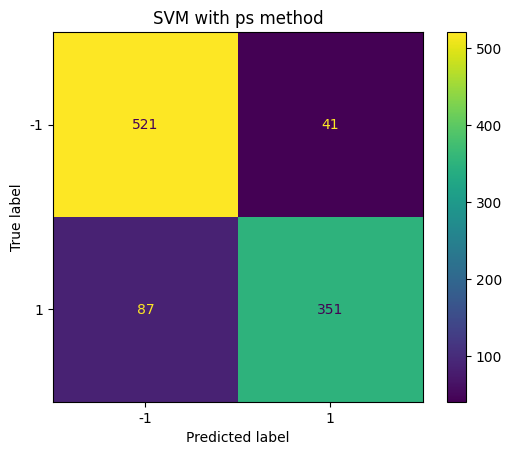

ACC = 0.872, F1 = 0.8457831325301205, PPV = 0.8954081632653061, NPV = 0.8569078947368421, TPR = 0.8013698630136986, TNR = 0.9270462633451957, FPR = 0.07295373665480427, FNR = 0.19863013698630136

TP = 351, FP = 41, TN = 521, FN = 87


In [17]:
metricsPSR = EvaluateModel(model, Xts[:,-4:], Yts, f"SVM with {model.method} method")

In [18]:
joblib.dump(model,datapath+"PS_SVM_safe.sav")

['simulationVictorTopological/PS_SVM_safe.sav']

In [19]:
# save to file
y_ps_tr = model.predict(Xtr[:,-4:]).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal[:,-4:]).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts[:,-4:]).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr[:,-4:],Ytr,y_ps_tr)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal[:,-4:],Ycal,y_ps_cal)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts[:,-4:],Yts,y_ps_ts)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
train.to_csv(datapath+"train_ps.csv", index = False)
calib.to_csv(datapath+"calib_ps.csv", index = False)
test.to_csv(datapath+"test_ps.csv", index = False)

# 3) Conformal Safety Regions


In [20]:
model = model.FPcontrol(Xcal[:,-4:], Ycal, 0.1,'cp')
model.get_params()

{'alpha': array([4.99955410e-01, 5.00036436e-01, 4.99884052e-01, ...,
        4.99870439e-01, 6.92332551e-05, 4.99887713e-01]),
 'b': array([-0.15650505]),
 'b_eps': 0.16890016282061415,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

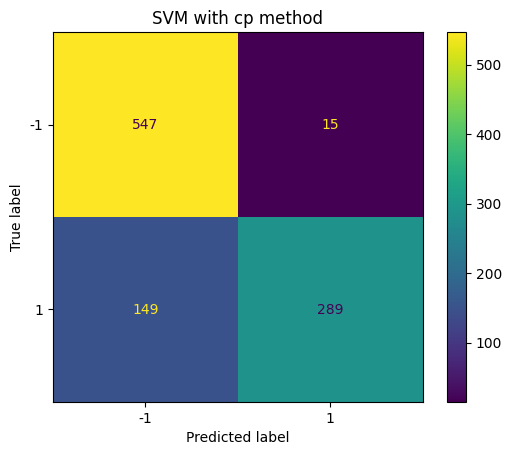

ACC = 0.836, F1 = 0.7789757412398922, PPV = 0.9506578947368421, NPV = 0.7859195402298851, TPR = 0.6598173515981736, TNR = 0.9733096085409253, FPR = 0.026690391459074734, FNR = 0.3401826484018265

TP = 289, FP = 15, TN = 547, FN = 149


In [21]:
metricsCSR = EvaluateModel(model, Xts[:,-4:], Yts, f"SVM with {model.method} method")

In [22]:
joblib.dump(model,datapath+"CP_SVM_safe.sav")

['simulationVictorTopological/CP_SVM_safe.sav']

In [23]:
# save to file
y_ps_tr = model.predict(Xtr[:,-4:]).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal[:,-4:]).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts[:,-4:]).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr[:,-4:],Ytr,y_ps_tr)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal[:,-4:],Ycal,y_ps_cal)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts[:,-4:],Yts,y_ps_ts)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
train.to_csv(datapath+"train_cp.csv", index = False)
calib.to_csv(datapath+"calib_cp.csv", index = False)
test.to_csv(datapath+"test_cp.csv", index = False)